In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
import random
import pickle
from scipy.stats.mstats import winsorize

random.seed(0)

# Load the dataset
f = open("BTC_USD_2018-01-01_2020-12-31-CoinDesk.csv", "r")
coindesk_data = pd.read_csv(f, header=0)
seq = coindesk_data[['Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']].to_numpy()
seq = coindesk_data[['Closing Price (USD)']].to_numpy()

# Function to apply Winsorizing
def winsorize_data(data, limits):
    return winsorize(data, limits=limits)

# Apply Winsorizing to the data (e.g., replace extreme 5% values on both ends)
seq_winsorized = winsorize_data(seq.flatten(), limits=[0.05, 0.05]).reshape(-1, 1)

n_epochs = 20
batch_size = 32
n_trials = 2
mode = 1  # 1: experiment1(single horizon), 2: experiment2(multi horizons), 3: experiment3(effect of length of time series T)

def seq2dataset(seq, window, horizon):
    X = []
    Y = []
    for i in range(window[0] - 1, len(seq) - horizon):
        for k in range(len(window)):
            x = seq[i - window[k] + 1:i + 1]
            y = seq[i + horizon]
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

if mode == 1:  # single-step mode
    perf1, perf2 = [], []

    for w in range(18, 21):
        for s in range(10):
            frame = [w, w]
            h = 5

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq_winsorized, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq_winsorized) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            model = Sequential()
            model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=(w, 1)))
            model.add(Flatten())
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['mae'])

            for i in range(n_epochs):
                for j in range(len(x_train)):
                    model.train_on_batch(x_train[j], y_train[j])

                pred = []
                for j in range(len(x_train)):
                    pred.append(model.predict(x_test[j]))

                ave = np.mean(pred, axis=0)
                for k in range(len(pred)):
                    pred[k] = ave

                mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)

            perf1.append(mape)

            frame = [max(w - 2, 1), w]
            h = 5

            X, Y = [], []
            for i in range(frame[0], frame[1] + 1):
                x, y = seq2dataset(seq_winsorized, [i], h)
                X.append(x)
                Y.append(y)

            x_train, y_train = [], []
            x_test, y_test = [], []

            split = int(len(seq_winsorized) * 0.3)  # ratio for test set

            for i in range(len(X)):
                x_test.append(X[i][-split:])
                y_test.append(Y[i][-split:])
                x_train.append(X[i][0:-split])
                y_train.append(Y[i][0:-split])

            pred = []
            for j in range(len(x_train)):
                model = Sequential()
                model.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=(x_train[j].shape[1], 1)))
                model.add(Flatten())
                model.add(Dense(1))
                model.compile(loss='mae', optimizer='adam', metrics=['mae'])

                for i in range(n_epochs):
                    model.train_on_batch(x_train[j], y_train[j])

                pred.append(model.predict(x_test[j]))

            ave = np.mean(pred, axis=0)
            for k in range(len(pred)):
                pred[k] = ave

            mape = np.mean(np.mean(abs(np.array(y_test) - pred) / abs(np.array(y_test)), axis=0), axis=0)

            perf2.append(mape)

# Print the results
print("Performance 1 (MAPE):", perf1)
print("Performance 2 (MAPE):", perf2)


11/11 [==============================] - 0s 2ms/step
Performance 1 (MAPE): [array([0.08362597]), array([0.14210839]), array([0.08982195]), array([0.15434658]), array([0.14602428]), array([0.15775374]), array([0.11808344]), array([0.08640031]), array([0.15641828]), array([0.17375628]), array([0.37278243]), array([0.14442837]), array([0.13805521]), array([0.13789624]), array([0.17570349]), array([0.09115003]), array([0.19286601]), array([0.13674696]), array([0.09201963]), array([0.15038207]), array([0.16778289]), array([0.17198476]), array([0.13046697]), array([0.09222102]), array([0.18412012]), array([0.24538884]), array([0.165056]), array([0.2256799]), array([0.08320325]), array([0.12641123])]
Performance 2 (MAPE): [array([0.09918658]), array([0.09140468]), array([0.14224844]), array([0.09786097]), array([0.09013737]), array([0.12748309]), array([0.07420465]), array([0.09583734]), array([0.14486984]), array([0.12002115]), array([0.07754688]), array([0.12394567]), array([0.10965732]), a

Performance 1 (MAPE): [array([0.08362597]), array([0.14210839]), array([0.08982195]), array([0.15434658]), array([0.14602428]), array([0.15775374]), array([0.11808344]), array([0.08640031]), array([0.15641828]), array([0.17375628]), array([0.37278243]), array([0.14442837]), array([0.13805521]), array([0.13789624]), array([0.17570349]), array([0.09115003]), array([0.19286601]), array([0.13674696]), array([0.09201963]), array([0.15038207]), array([0.16778289]), array([0.17198476]), array([0.13046697]), array([0.09222102]), array([0.18412012]), array([0.24538884]), array([0.165056]), array([0.2256799]), array([0.08320325]), array([0.12641123])]
Performance 2 (MAPE): [array([0.09918658]), array([0.09140468]), array([0.14224844]), array([0.09786097]), array([0.09013737]), array([0.12748309]), array([0.07420465]), array([0.09583734]), array([0.14486984]), array([0.12002115]), array([0.07754688]), array([0.12394567]), array([0.10965732]), array([0.13521013]), array([0.12728714]), array([0.143

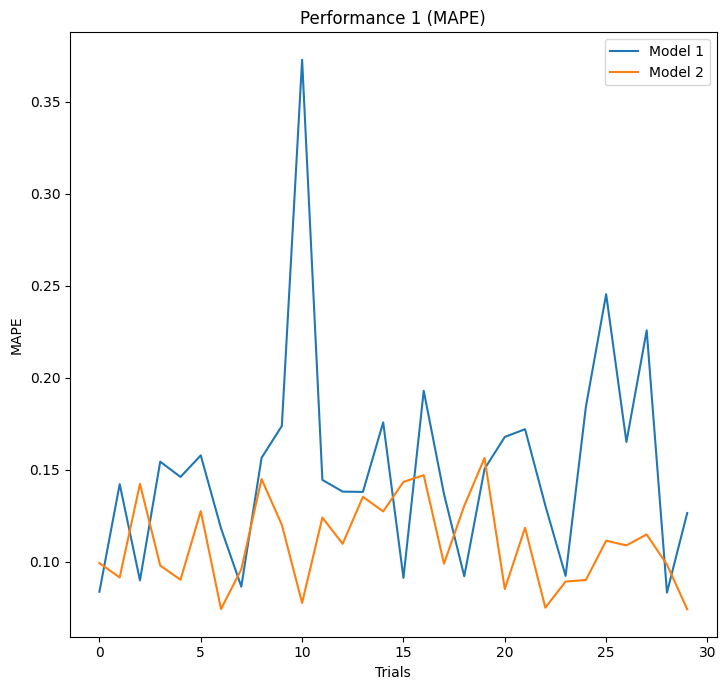

In [3]:
import matplotlib.pyplot as plt

# Print the results
print("Performance 1 (MAPE):", perf1)
print("Performance 2 (MAPE):", perf2)

# Plotting the data
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(perf1, label='Model 1')
plt.plot(perf2, label='Model 2')
plt.xlabel('Trials')
plt.ylabel('MAPE')
plt.title('Performance 1 (MAPE)')
plt.legend()

plt.tight_layout()
plt.show()